In [0]:
!wget http://qwone.com/%7Ejason/20Newsgroups/20news-bydate.tar.gz

--2020-04-23 11:17:03--  http://qwone.com/%7Ejason/20Newsgroups/20news-bydate.tar.gz
Resolving qwone.com (qwone.com)... 108.20.201.166
Connecting to qwone.com (qwone.com)|108.20.201.166|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14464277 (14M) [application/x-gzip]
Saving to: ‘20news-bydate.tar.gz’

20news-bydate.tar.g 100%[===================>]  13.79M  5.30MB/s    in 2.6s    

2020-04-23 11:17:06 (5.30 MB/s) - ‘20news-bydate.tar.gz’ saved [14464277/14464277]



In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-04-23 11:17:09--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.92.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.92.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.1MB/s    in 46s     

2020-04-23 11:17:55 (34.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
!gunzip GoogleNews-vectors-negative300.bin.gz 

In [0]:
!tar -xzf 20news-bydate.tar.gz

In [0]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

import matplotlib.pyplot as plt
import time

from model import ConvNet
from CustomDataset import get_dataset


In [63]:

NUM_MAPS = 10
LEARNINGRATE = 8e-3
GAMMA = 0.9

BATCHSIZE = 512
NUMEPOCHS = 11

LOG_SOFTMAX_VALUES = False

dset = get_dataset('20news-bydate-test')

FILE = 'Model_quicksave4.pt'
random.seed(12)
np.random.seed(12)

class_names = dset.classes
print(class_names)


rand_files = random.sample(range(len(dset)), NUM_MAPS)


model = ConvNet(LOG_SOFTMAX_VALUES)
model.load_state_dict(torch.load(FILE))
model.eval()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
print('Building model..')	
model.to(device)
print('Model Built.')



print('Printing Parameters')
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

print('---Printing Parameters Finished!---')


['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Running on cuda:0
Building model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
---Printing Parameters Finished!---


In [0]:
def GenRelMap(x, num_iters=400, lr =8e-3, gam = 0.95 , lamb = 750 ):


    s = 0.1*np.random.rand(1,x.shape[2],1)
    #s = 0.5*np.ones((1,x.shape[2],1)) 
    s = torch.as_tensor(s.astype(np.float32)).to(device)
    s = torch.autograd.Variable(s, requires_grad=True)

    
    optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)

    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
    print(x_input.shape)
    print(highest_dim)
    for i in range(num_iters):

        n = torch.as_tensor(np.random.normal(size=(BATCHSIZE, *(x.shape[1:]))).astype(np.float32)).to(device)
        
        data_input = (x_input-n)*s+n
        out = model(data_input)

        loss = 0.5*torch.mean((out[:, highest_dim]-x_out[:, highest_dim])**2)+lamb*torch.mean(torch.abs(s))

        if (i)%50==0:
            print("Net loss:{:.5f}, MSE:{:.5f}, L1:{:.5f}".format(loss.data.item(),
                                                                  0.5*torch.mean((out[:, highest_dim]-x_out[:, highest_dim])**2).data.item(),
                                                                  lamb*torch.mean(torch.abs(s)).data.item()))
            print(list(np.argmax(out.detach().cpu().numpy(), axis=1)).count(highest_dim)*100.0/BATCHSIZE)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            s += s.clamp_(0,1) - s

            #print(s)
            #print(s.grad)
            #print(0.5*torch.mean((out[:, highest_dim]-x_out[:, highest_dim])**2).data.item())
            #print(lamb*torch.mean(torch.abs(s)).data.item())
          
        scheduler.step()

    return s.detach().cpu().numpy()


In [163]:
#NUM_MAPS = 10
#rmap = [None]*10
counter = 7

d = dset.get_custom_matrix(rand_files[counter])
e = dset.get_words_list(rand_files[counter])
print(len(e))

sample, target, path = dset[rand_files[counter]]
sample = dset.get_custom_matrix(rand_files[counter])
sample = sample[None,None,:,:]
print(target)
print(sample.shape)

x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
x_out = model(x_input.clone()).detach().cpu()
if np.argmax(x_out) != target: print("WRONG")
print(x_out)

print(path)


134
8
(1, 1, 134, 300)
WRONG
tensor([[-0.3062, -0.4790, -0.4211, -0.4264, -0.3024, -0.1600, -0.2513, -0.3133,
         -0.1904, -0.1658, -0.2158, -0.3549, -0.3907, -0.1573, -0.1888, -0.2656,
         -0.2215, -0.5029, -0.2454, -0.1099]])
20news-bydate-test/rec.motorcycles/104758


In [164]:
rmap = rel_map_normal = GenRelMap(sample, num_iters=401, lamb=7, gam=0.98, lr = 5e-3)


torch.Size([1, 1, 134, 300])
19
Net loss:1.08880, MSE:0.76807, L1:0.32073
0.0
Net loss:0.87359, MSE:0.87348, L1:0.00011
0.0
Net loss:0.85348, MSE:0.85344, L1:0.00005
0.0
Net loss:0.86291, MSE:0.86290, L1:0.00001
0.0
Net loss:0.86976, MSE:0.86976, L1:0.00001
0.0
Net loss:0.86144, MSE:0.86144, L1:0.00000
0.0
Net loss:0.86134, MSE:0.86134, L1:0.00000
0.0
Net loss:0.84904, MSE:0.84904, L1:0.00000
0.0
Net loss:0.87159, MSE:0.87159, L1:0.00000
0.0


In [165]:
rmap[0,:,0]

array([0.0000000e+00, 1.1023010e-09, 3.5450292e-08, 2.8334659e-09,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.3531504e-08, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0655478e-07, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.8213812e-08,
       1.1260634e-07, 2.9898189e-08, 2.9415130e-08, 0.0000000e+00,
       5.4009586e-08, 0.0000000e+00, 1.1008815e-07, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       6.5188299e-09, 4.7603601e-09, 0.0000000e+00, 3.9651550e-08,
       0.0000000e+00, 0.0000000e+00, 5.1020251e-08, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.0988120e-08, 7.0445914e-08,
       7.1474211e-08, 0.0000000e+00, 5.6537253e-08, 1.3269657e

In [0]:
# This is a utility method visualizing the relevance scores of each word tothe network's prediction. 
# one might skip understanding the function, and see its output first.
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, title="", width=14, height=0.3, verbose=0, max_word_per_line=15):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]

    # ^^^^ For our application 0 to 1 is enough but it gives rather poor representation as most words mapped to 0 would be
    # In blue!

    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token, size='large',
                       bbox={#'width':12,
                             #'height':2,
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'square,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.0
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+19, units='dots')

    if verbose == 0:
        ax.axis('off')


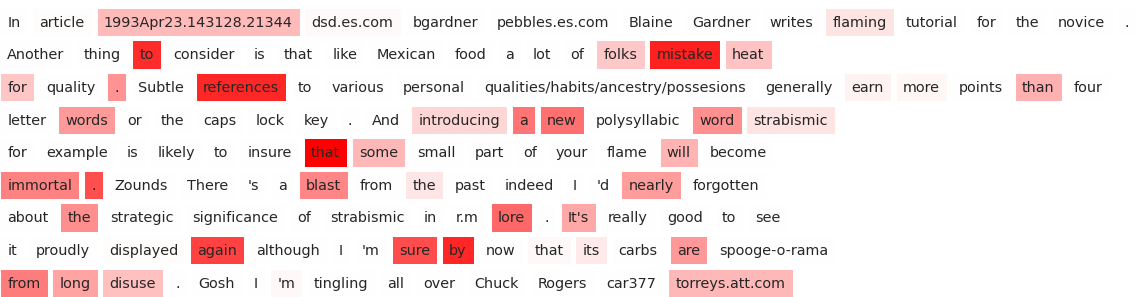

In [167]:
plot_text_heatmap(e,rmap[0,:,0])

In [0]:
indx = sorted(range(len(rmap[0,:,0])), key=lambda k: rmap[0,k,0])

In [0]:
wd = [e[i] for i in indx]

In [0]:
wd = wd[::-1]
wd = wd[:6]

In [171]:
wd

['that', 'mistake', 'by', 'references', 'to', 'again']

In [0]:
rmap = rmap[0,:,0]
smap = [rmap[i] for i in indx]

In [173]:
smap = smap[::-1]
smap = smap[:6]
smap

[1.2984609e-07,
 1.1260634e-07,
 1.1025828e-07,
 1.1008815e-07,
 1.0655478e-07,
 9.625133e-08]

        Words          RMap
0        that  1.298461e-07
1     mistake  1.126063e-07
2          by  1.102583e-07
3  references  1.100882e-07
4          to  1.065548e-07


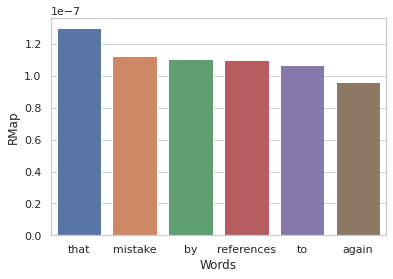

In [174]:
import seaborn as sns
import pandas as pd

x = pd.DataFrame(wd,columns=['Words'])
x['RMap'] = smap
print(x.head())
sns.set(style="whitegrid")


ax = sns.barplot(x="Words", y="RMap", data=x)
